## Modules à importer

In [23]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa.variaIa import baserate
from importlib import reload
from variaIa.variaIa import stretchevol
from scipy.stats import poisson
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}
    
with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
        datax = np.sort(surv[su]['salt2.X1'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
        datax = np.sort(surv[su].x1.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

## Choix des bins pour les listes de redshifts et de stretch

In [3]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Tracé des redshifts de l'échantillon choisi

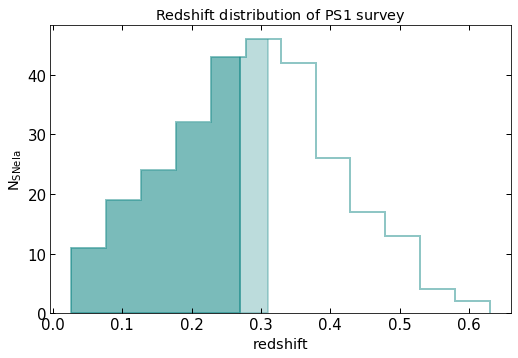

In [5]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

N, _, patches = ax.hist(dataz, bins = nb_z.value, color=colors[su.value],
                        alpha = .5, histtype='step', lw=2)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.axvspan(np.min(surv[su.value].zCMB),
           z_max[su.value][0],
           color=colors[su.value],
           alpha=.6, lw=2.0,
           clip_path=patches[0])
ax.axvspan(z_max[su.value][0],
           z_max[su.value][1],
           color=colors[su.value],
           alpha=.3, lw=2.0,
           clip_path=patches[0])

plt.title(r'$\mathrm{Redshift\,\,distribution\,\,of\,\,}$' + str(su.value) +
          r'$\mathrm{\,\,survey}$', fontsize = 'x-large')

fig=plt.gcf()
#fig.savefig('../../../Images/hist_'
#            + str(su.value) + '_maglim-cuts.pdf', bbox_inches='tight')

## Définitions des dictionnaires

### $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, data_all, mean et std

In [27]:
zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]
c_zcuts['SNF'] = surv['SNF']['salt2.Color'].values[zmax_cuts['SNF']]
c_err_zcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zmax_cuts['SNF']]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])

In [6]:
s = 0
for survey in surveys:
    s += len(z_zcuts[survey])
    print(survey + ' = ', len(z_zcuts[survey]))

print('Sum = ', s)

SNF =  141
SDSS =  167
PS1 =  160
SNLS =  102
HST =  26
Sum =  596


### $[z_{\text{max}}:]$

In [5]:
zmin_cuts = dict()
z_zmincuts = dict()
x1_zmincuts = dict()
x1_err_zmincuts = dict()
c_zmincuts = dict()
c_err_zmincuts = dict()

for survey in surveys[1:]:
    zmin_cuts[survey] = np.where(surv[survey].zCMB.values > z_max[survey][1])
    z_zmincuts[survey] = surv[survey].zCMB.values[zmin_cuts[survey]]
    x1_zmincuts[survey] = surv[survey].x1.values[zmin_cuts[survey]]
    x1_err_zmincuts[survey] = surv[survey].x1ERR.values[zmin_cuts[survey]]
    c_zmincuts[survey] = surv[survey].c.values[zmin_cuts[survey]]
    c_err_zmincuts[survey] = surv[survey].cERR.values[zmin_cuts[survey]]
    
zmin_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values > z_max['SNF'][1])
z_zmincuts['SNF'] = surv['SNF']['host.zcmb'].values[zmin_cuts['SNF']]
x1_zmincuts['SNF'] = surv['SNF']['salt2.X1'].values[zmin_cuts['SNF']]
x1_err_zmincuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmin_cuts['SNF']]
c_zmincuts['SNF'] = surv['SNF']['salt2.Color'].values[zmin_cuts['SNF']]
c_err_zmincuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zmin_cuts['SNF']]

### $[z_{\text{max, inf}}:z_{\text{max, sup}}]$

In [6]:
zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys[1:-1]:
    zbtw_cuts[survey] = np.where((surv[survey].zCMB.values > z_max[survey][0])
                               & (surv[survey].zCMB.values < z_max[survey][1]))
    z_zbtwcuts[survey] = surv[survey].zCMB.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = surv[survey].x1.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = surv[survey].x1ERR.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = surv[survey].c.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = surv[survey].cERR.values[zbtw_cuts[survey]]

### $[:z_{\text{inf}}]$, $[z_{\text{sup}}:]$ et mean_inf

In [9]:
zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys[1:]:
    zinf_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
    z_zinfcuts[survey] = surv[survey].zCMB.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = surv[survey].x1.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = surv[survey].x1ERR.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = surv[survey].c.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = surv[survey].cERR.values[zinf_cuts[survey]]
    
zinf_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][0])
z_zinfcuts['SNF'] = surv['SNF']['host.zcmb'].values[zinf_cuts['SNF']]
x1_zinfcuts['SNF'] = surv['SNF']['salt2.X1'].values[zinf_cuts['SNF']]
x1_err_zinfcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zinf_cuts['SNF']]
c_zinfcuts['SNF'] = surv['SNF']['salt2.Color'].values[zinf_cuts['SNF']]
c_err_zinfcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zinf_cuts['SNF']]
    
z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys[1:-1]:
    zsup_cuts[survey] = np.where(surv[survey].zCMB.values > z_max[survey][1])
    z_zsupcuts[survey] = surv[survey].zCMB.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = surv[survey].x1.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = surv[survey].x1ERR.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = surv[survey].c.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = surv[survey].cERR.values[zsup_cuts[survey]]

## Tracé du stretch de l'échantillon choisi, coupé à zmax

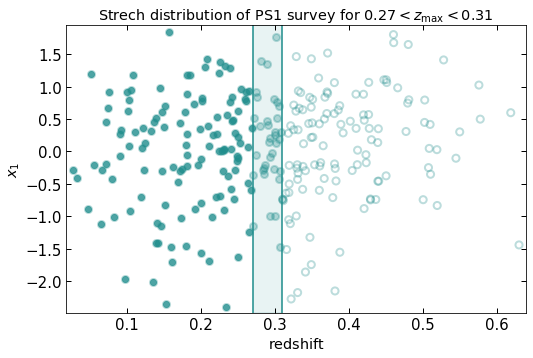

In [9]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha3colors = dict()

for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()

for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

ax.scatter(z_zinfcuts[su.value],
           x1_zinfcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor=alpha8colors[su.value],
           label=su.value)

ax.scatter(z_zbtwcuts[su.value],
           x1_zbtwcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor=alpha3colors[su.value],
           label=su.value)

ax.scatter(z_zsupcuts[su.value],
           x1_zsupcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor="None")

ax.vline(z_max[su.value][0],
         color=colors[su.value])
ax.vline(z_max[su.value][1],
         color=colors[su.value])
ax.axvspan(z_max[su.value][0],
           z_max[su.value][1],
           color = colors[su.value],
           alpha=.1, lw=2.0)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax.set_xlim(np.min(z_zinfcuts[su.value])-1e-2, np.max(z_zsupcuts[su.value])+1e-2)
ax.set_ylim(np.min(x1_zinfcuts[su.value])-1e-1, np.max(x1_zinfcuts[su.value])+1e-1)

plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,}$'
          + str(su.value)
          + r'$\mathrm{\,\,survey\,\,for\,\,}$'
          + str(z_max[su.value][0])
          + r'$< z_{\mathrm{max}} < $'
          + str(z_max[su.value][1]), fontsize = 'x-large')

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretch_'
#            + str(su.value) + '_spec_cuts.pdf', bbox_inches='tight')

## Tracé des stretchs cut à $z_{\text{max}}$

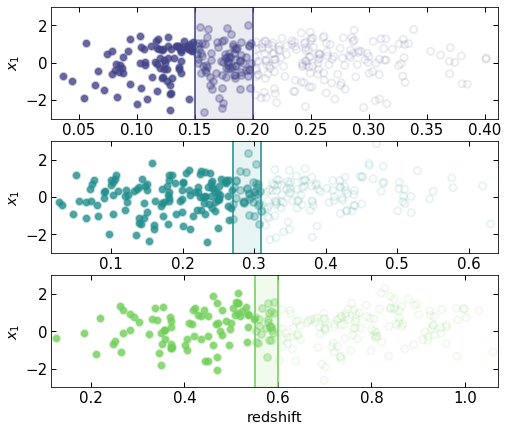

In [10]:
#plt.style.use('dark_background')
#plt.style.use('seaborn-white')

fig = plt.figure(figsize = [8, 7])

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

i = 1
for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    
    ax.scatter(z_zinfcuts[survey],
               x1_zinfcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor=alpha8colors[survey],
               label=survey)

    ax.scatter(z_zbtwcuts[survey],
               x1_zbtwcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor=alpha3colors[survey])

    ax.scatter(z_zsupcuts[survey],
               x1_zsupcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor="None",
               alpha=.1)

    ax.vline(z_max[survey][0],
             color=colors[survey])
    ax.vline(z_max[survey][1],
             color=colors[survey])
    ax.axvspan(z_max[survey][0],
               z_max[survey][1],
               color = colors[survey],
               alpha=.1, lw=2.0)

    ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

    ax.set_xlim(np.min(z_zinfcuts[survey])-1e-2, np.max(z_zsupcuts[survey])+1e-2)
#    ax.set_ylim(np.min(x1_zinfcuts[survey])-1e-1, np.max(x1_zinfcuts[survey])+1e-1)
    
#    ax.set_xlim(0, 1.1)
    ax.set_ylim(-3, 3)
    
    ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)
    
#    ax.legend(ncol=1, loc='lower left', fontsize='medium',
#              bbox_to_anchor=(0.82, 0.60))
    i += 1

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')

#plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,}$'
#          + str(survey)
#          + r'$\mathrm{\,\,survey\,\,for\,\,}$'
#          + str(z_max[survey][0])
#          + r'$< z_{\mathrm{max}} < $'
#          + str(z_max[survey][1]), fontsize = 'x-large')

fig=plt.gcf()
#fig.savefig('../../../Images/stretchs_maglim_cuts.pdf', bbox_inches='tight')

## Tracé total : histogrammes

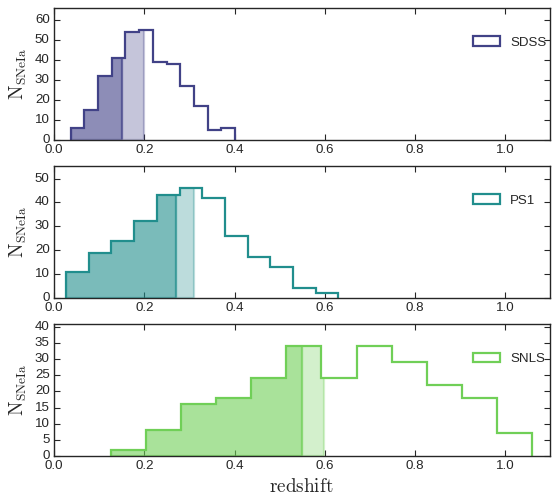

In [27]:
plt.style.use(['classic', 'seaborn-white'])

fig = plt.figure(figsize=[8, 7])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

i = 1

for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    N, _, patches = ax.hist(surv[survey].zCMB, bins=nb_x.value,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    
#    ax.vline(z_max[survey][0],
#             color=colors[survey])
#    ax.vline(z_max[survey][1],
#             color=colors[survey])
    ax.axvspan(np.min(surv[survey].zCMB),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])
    ax.axvspan(z_max[survey][0],
               z_max[survey][1],
               color=colors[survey],
               alpha=.3, lw=2.0,
               clip_path=patches[0])
#    ax.axvspan(z_max[survey][1],
#               np.max(surv[survey].zCMB),
#               color = colors[survey],
#               alpha=.1, lw=2.0,
#               clip_path=patches[0])

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)
    
    ax.legend(ncol=1, loc='lower left', fontsize='medium',
          bbox_to_anchor=(0.82, 0.60))
    i += 1

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")

fig=plt.gcf()
#fig.savefig('../../../Images/hist_surveys_cuts.pdf', bbox_inches='tight')

## Tracé total : $x_1$ at zmax

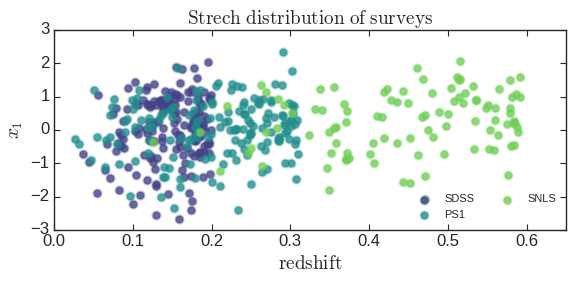

In [94]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.5])

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=50, lw=2)

for survey in surveys[1:-1]:
    ax.scatter(z_zcuts[survey],
               x1_zcuts[survey],
               edgecolor=alpha3colors[survey],
               facecolor=alpha8colors[survey],
               label=survey, **prop)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax.set_xlim(0, 0.65)
ax.set_ylim(-3, 3)

ax.legend(loc="lower right", ncol=2, fontsize="small")

plt.title(r'$\mathrm{Strech\,\,distribution\,\,of}$'
          + r'$\mathrm{\,\,surveys}$',
          fontsize = 'x-large')

fig=plt.gcf()
fig.savefig('../../../Images/stretch_maglim-cut.pdf', bbox_inches='tight')

## Tracé total : $x_1$ at zmax_cons, btw, sup

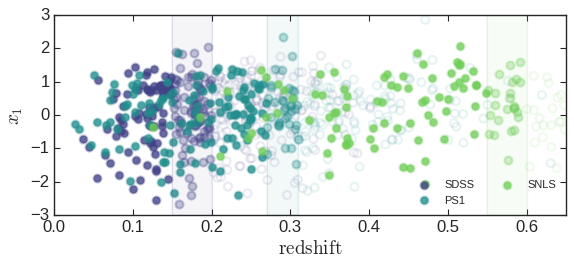

In [95]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=50, lw=2)

for survey in surveys[1:-1]:
    ax.scatter(z_zinfcuts[survey],
               x1_zinfcuts[survey],
               edgecolor=alpha3colors[survey],
               facecolor=alpha8colors[survey],
               label=survey, **prop)
    
    ax.scatter(z_zbtwcuts[survey],
               x1_zbtwcuts[survey],
               edgecolor=alpha3colors[survey],
               facecolor=alpha3colors[survey],
               **prop)
    
    ax.scatter(z_zsupcuts[survey],
               x1_zsupcuts[survey],
               edgecolor=alpha1colors[survey],
               facecolor="None",
               **prop)
    
    ax.vline(z_max[survey][0],
             color=colors[survey],
             alpha=.1)
    ax.vline(z_max[survey][1],
             color=colors[survey],
             alpha=.1)
    ax.axvspan(z_max[survey][0],
               z_max[survey][1],
               color=colors[survey],
               alpha=.05, lw=2.0)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax.set_xlim(0, 0.65)
ax.set_ylim(-3, 3)

ax.legend(loc="lower right", ncol=2, fontsize="small")

#plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,surveys}$',
#          fontsize = 'x-large')

fig=plt.gcf()
fig.savefig('../../../Images/stretch_maglim-cuts.pdf', bbox_inches='tight')

## Tracé total : $x_1$, $c$ at zmax_cons, btw, sup, violins

### Définition des bins sur lesquels faire les violins

In [30]:
int(True)

1

In [32]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

def set_cons(cons):
    global z_zcuts, x1_zcuts, c_zcuts,\
           datax_all, datax_err_all, dataz_all
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    c_zcuts = dict()
    c_err_zcuts = dict()

    for survey in surveys[1:]:
        zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1-int(cons)])
        z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
        x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
        x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
        c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
        c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]

    zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1-int(cons)])
    z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
    x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
    x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]
    c_zcuts['SNF'] = surv['SNF']['salt2.Color'].values[zmax_cuts['SNF']]
    c_err_zcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zmax_cuts['SNF']]

    datax_all = (np.concatenate(
        (np.concatenate(
            (x1_zcuts['SDSS'],
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])))

    datax_err_all = (np.concatenate(
        (np.concatenate(
            (x1_err_zcuts['SDSS'],
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])))

    dataz_all = (np.concatenate(
        (np.concatenate(
            (z_zcuts['SDSS'],
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])))

    z_mean = dict()
    z_std = dict()
    x1_mean = dict()
    x1_std = dict()
    c_mean = dict()
    c_std = dict()

    for survey in surveys:
        z_mean[survey] = np.mean(z_zcuts[survey])
        z_std[survey] = np.std(z_zcuts[survey])
        x1_mean[survey] = np.mean(x1_zcuts[survey])
        x1_std[survey] = np.std(x1_zcuts[survey])
        c_mean[survey] = np.mean(c_zcuts[survey])
        c_std[survey] = np.std(c_zcuts[survey])

int_set_cons = ipw.interactive(set_cons, cons=cons)

btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')
violin = ipw.Checkbox(
    value=False,
    description='Violin')
ipw.HBox([int_set_cons, btw, after, violin])

In [25]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

### Tracé

In [256]:
vio_bins = [0, 0.2, 0.4, 0.6]

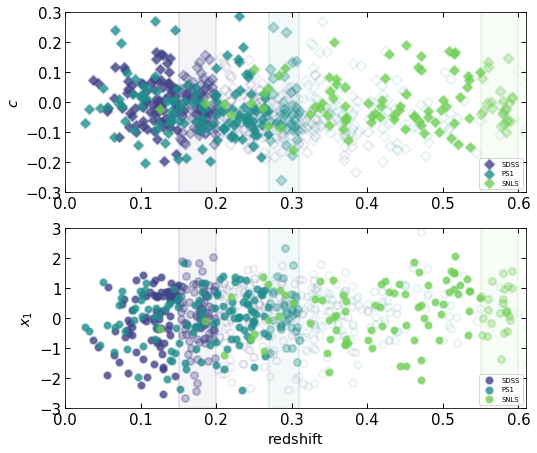

In [47]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.5])
ax2 = fig.add_axes([0.1, 0.72, 0.8, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=50, lw=2)
prop2 = dict(marker="D", s=50, lw=2)

_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in surveys[1:-1]:
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha8colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha3colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
        ax2.scatter(z_zinfcuts[survey],
                    c_zinfcuts[survey],
                    edgecolor=alpha3colors[survey],
                    facecolor=alpha8colors[survey],
                    label=survey, **prop2)
        ax2.scatter(z_zbtwcuts[survey],
                    c_zbtwcuts[survey],
                    edgecolor=alpha3colors[survey],
                    facecolor=alpha3colors[survey],
                    **prop2)
        
        ax2.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax2.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax2.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)

    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   edgecolor=alpha3colors[survey],
                   facecolor=alpha8colors[survey],
                   label=survey, **prop)
        ax2.scatter(z_zcuts[survey],
                    c_zcuts[survey],
                    edgecolor=alpha3colors[survey],
                    facecolor=alpha8colors[survey],
                    label=survey, **prop2)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   edgecolor=alpha1colors[survey],
                   facecolor="None",
                   **prop)
        ax2.scatter(z_zsupcuts[survey],
                    c_zsupcuts[survey],
                    edgecolor=alpha1colors[survey],
                    facecolor="None",
                    **prop2)

propl = dict(lw=1, color="0.7", ls='--')

if violin.value:
    ax.hline(2, **propl)
    ax.hline(-2, **propl)

    ax.vline(vio_bins[0], **propl)
    ax.vline(vio_bins[1], **propl)
    ax.vline(vio_bins[2], **propl)
    ax.vline(vio_bins[3], **propl)

    ya, xa = np.histogram(datax_all,
                          bins=nb_x.value, density=True)

    for i in range(3):
        y, x = np.histogram(datax_all[np.where((dataz_all > vio_bins[i])
                                             & (dataz_all < vio_bins[i+1]))],
                              bins=nb_x.value, density=True)
        ax.barh(y=x[:-1], width=y/10, height=x[1]-x[0],
                left=(vio_bins[i]+vio_bins[i+1])/2,
                color="0.7", alpha=.7, lw=1, edgecolor="0")
        ax.barh(y=xa[:-1], width=-ya/10, height=xa[1]-xa[0],
                left=(vio_bins[i]+vio_bins[i+1])/2,
                color="0.7", alpha=.7, lw=1, edgecolor="0")
    
ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)
ax2.tick_params(direction = 'in',
                length = 5, width = 1,
                labelsize = 15,
                top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')
ax2.set_ylabel(r'$c$', fontsize = 'x-large')

ax.set_xlim(0, 0.61)
ax.set_ylim(-3, 3)
ax2.set_xlim(0, 0.61)
ax2.set_ylim(-.3, .3)

ax.legend(loc="lower right", ncol=1, fontsize="x-small")
ax2.legend(loc="lower right", ncol=1, fontsize="x-small")

#plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,surveys}$',
#          fontsize = 'x-large')

fig=plt.gcf()

path = '../../../Images/both_maglim-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
if violin.value:
    path = path + '_violin'
    
path = path + '.pdf'
fig.savefig(path, bbox_inches='tight')

In [40]:
def gauss(x, dx, mu, sigma):
    '''Le modèle de distribution'''
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

In [61]:
xx = np.linspace(-5, 5, 100)
G = dict()
Z = dict()
for i in range(3):
    Z[i] = dataz_all[np.where((dataz_all > vio_bins[i])
                            & (dataz_all < vio_bins[i+1]))]
    G[i] = gauss(xx[:,None], 0,
                 datax_all[np.where((dataz_all > vio_bins[i])
                                 & (dataz_all < vio_bins[i+1]))],
                 datax_err_all[np.where((dataz_all > vio_bins[i])
                                   & (dataz_all < vio_bins[i+1]))])

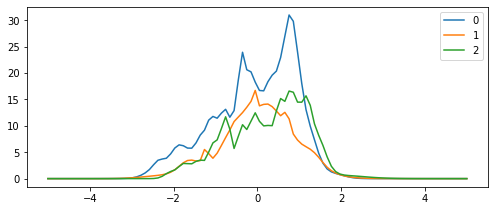

In [75]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.5])

for i in range(3):
    ax.plot(xx, np.sum(G[i].T, axis=0)/2.3, label=str(i))

ax.legend()

In [ ]:
y1, x1 = np.histogram(datax_all[np.where((dataz_all > vio_bins[0])
                                       & (dataz_all < vio_bins[1]))],
                      bins=nb_x.value, density=True)
ax.barh(y=x1[:-1], width=y1/6, height=x1[1]-x1[0],
        left=vio_bins[0] + (vio_bins[0]+vio_bins[1])/2,
        color="0.7", alpha=.7)
ax.barh(y=xa[:-1], width=-ya/6, height=xa[1]-xa[0],
        left=vio_bins[0] + (vio_bins[0]+vio_bins[1])/2,
        color="0.7", alpha=.7)

y2, x2 = np.histogram(datax_all[np.where((dataz_all > vio_bins[1])
                                       & (dataz_all < vio_bins[2]))],
                      bins=nb_x.value, density=True)
ax.barh(y=xa[:-1], width=-ya/6, height=xa[1]-xa[0],
        left=vio_bins[2]-vio_bins[1],
        color="0.7", alpha=.7)
ax.barh(y=x2[:-1], width=y2/6, height=x2[1]-x2[0],
        left=vio_bins[2]-vio_bins[1],
        color="0.7", alpha=.7)

y3, x3 = np.histogram(datax_all[np.where((dataz_all > vio_bins[2])
                                       & (dataz_all < vio_bins[3]))],
                      bins=nb_x.value, density=True)
ax.barh(y=xa[:-1], width=-ya/6, height=xa[1]-xa[0],
        left=vio_bins[3]-vio_bins[2],
        color="0.7", alpha=.7)
ax.barh(y=x3[:-1], width=y3/6, height=x3[1]-x3[0],
        left=vio_bins[3]-vio_bins[2],
        color="0.7", alpha=.7)

## Tracé total : $c$, $z$, $z_{\mathrm{cuts}}$, histogrammes

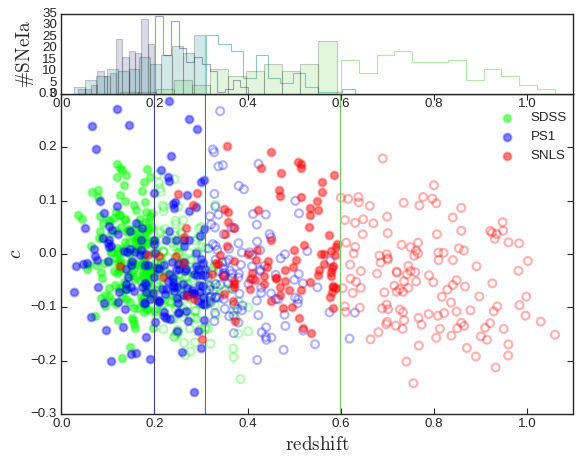

In [152]:
#plt.style.use(['classic', 'seaborn-white'])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha5colors = {'SDSS': (0,1,0,.5),
                'SNLS': (1,0,0,.5),
                'PS1': (0,0,1,.5),
                'HST': (.5,0,.5,.5),
                'SNF': (1,.647,0,.5)}

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
ax2 = fig.add_axes([0.1, 0.92, 0.8, 0.2])
#ax3 = fig.add_axes([0.9, 0.12, 0.2, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys[1:-1]:
    ax.scatter(z_zcuts[survey],
               c_zcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor=alpha5colors[survey],
               label=survey)
    ax.scatter(z_zmincuts[survey],
               c_zmincuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor="None")
    ax.vline(z_max[survey][1],
             color=colors[survey])
    
    ax2.hist(z_zcuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .2)
    ax2.hist(z_zmincuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .5, histtype='step')

#    ax3.hist(x1_zmincuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .2)
#    ax3.hist(x1_zcuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .5, histtype='step')
    
ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlim(0, 1.1)
ax.set_ylim(-.3, .3)
ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$c$ ", fontsize="x-large")

ax2.set_xlim(0, 1.1)
ax2.set_ylabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

#ax3.set_xlabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

ax.legend(ncol=1, loc='lower left', fontsize='medium',
          bbox_to_anchor=(0.82, 0.75))

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/surveys_cuts_c.pdf', bbox_inches='tight')

## Tracé des $x_1$, $c$ en fonction du $z$

(-0.4, 0.4)

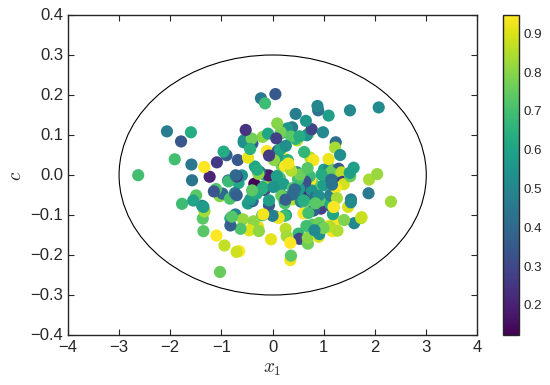

In [71]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

dgmap = plt.cm.get_cmap('viridis')

survey='SNLS'

ts = ax.scatter(surv[survey].x1,
                surv[survey].c,
                marker='o',
                cmap='viridis',
                c=surv[survey].zCMB, edgecolors="None",
                s=120,
                zorder=2,
                vmax=np.percentile(surv[survey].zCMB, 95))

fig.colorbar(ts)

ax.add_patch(Ellipse((0, 0),
             width=6,
             height=.6,
             ec="black",
             fc="1"))

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'$c$', fontsize='x-large')

#plt.legend(ncol=1, loc='upper left', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$

### Définitions pour loi

In [7]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

def delta(z):
    return stretchevol.MockEvol().delta(z)

def age_law_snf(z):
    """Analytical law with snf results"""
    return delta(z)*snf_mu_1 + (1-delta(z))*(snf_a*snf_mu_1 + (1-snf_a)*snf_mu_2)

### Tracé

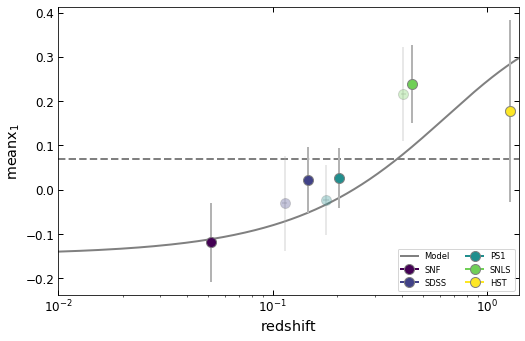

In [22]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys:
    ax.errorbar(z_mean[survey], x1_mean[survey],
                xerr = z_std[survey]/np.sqrt(len(z_zcuts[survey])),
                yerr = x1_std[survey]/np.sqrt(len(x1_zcuts[survey])),
                color = colors[survey], label = survey, **prop)
    ax.errorbar(z_inf_mean[survey], x1_inf_mean[survey], 
                xerr = z_inf_std[survey]/np.sqrt(len(z_zinfcuts[survey])),
                yerr = x1_inf_std[survey]/np.sqrt(len(x1_zinfcuts[survey])),
                color = colors[survey], **prop,
                alpha=.3)
    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(x1_mean.values())), lw=2, ls="--", color="0.5")

zz = np.linspace(0,1.4,1000)

ax.plot(zz, age_law_snf(zz),
        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean x}_1$ ", fontsize="x-large")

ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')
#ax.set_ylim(-0.3, 0.4)

ax.legend(loc='lower right',ncol=2, fontsize="small")

fig=plt.gcf()
fig.savefig('../../../Images/stretchevol_model_maglim-cuts.pdf', bbox_inches='tight')

## Tracé des $c_{\text{mean}}$ en fonction des $z_{\text{mean}}$

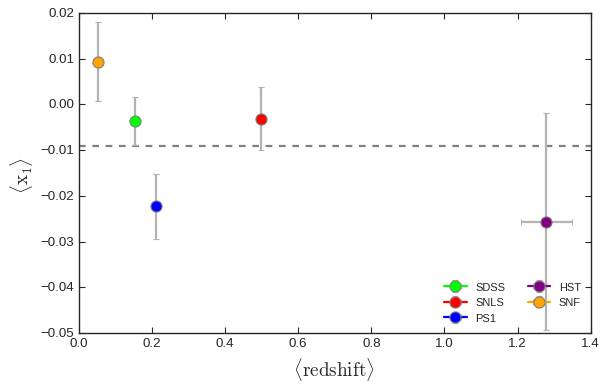

In [80]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
#    if i != 4:
#        continue
    ax.errorbar(list(z_mean.values())[i], list(c_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(c_std.values())[i]/np.sqrt(len(list(c_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(c_mean.values())), lw=2, ls="--", color="0.5")

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')